In [2]:
import math
import random
import time
import torch
import torch.optim as optim


from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.base_env import ActionTuple

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from models import DQN, DuelingDQN, ReplayMemory, optimize_model

def select_action(state_in):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            action_out = policy_net(state_in).max(1).indices.view(1, 1)
            return action_out
    else:
        return torch.tensor(spec.action_spec.random_action(1).discrete, device=device, dtype=torch.long)


In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

timer_start = time.perf_counter()
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 100_000
TAU = 0.005
LR = 1e-4

SAVE_WEIGHTS = True
LOAD_WEIGHTS = False
steps_done = 0
STEPS = 500
DOUBLE = False
DUELING = False
GRAPHICS = False

if torch.cuda.is_available():
    num_episodes = 10_000
else:
    num_episodes = 50


In [12]:

env = UnityEnvironment(file_name="unity_builds/snake", seed=13, side_channels=[], no_graphics=not GRAPHICS)
env.reset()

behaviour_name = list(env.behavior_specs)[0]
spec = env.behavior_specs[behaviour_name]

n_actions = spec.action_spec.discrete_branches[0]
state, _ = env.get_steps(behaviour_name)
state = state.obs[0]
# n_observations = len(state)
n_observations = spec.observation_specs[0].shape[0]

if DUELING:
    policy_net = DuelingDQN(n_observations, n_actions).to(device)
    target_net = DuelingDQN(n_observations, n_actions).to(device)
else:
    policy_net = DQN(n_observations, n_actions).to(device)
    target_net = DQN(n_observations, n_actions).to(device)

if LOAD_WEIGHTS:
    policy_net.load_state_dict(torch.load('weights/policy_net.pth'))
    print("Loaded weights from file")

target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000)
print(f"Initalized DQN with {n_observations} observations and {n_actions} actions")
rewards = []
losses = []

Initalized DQN with 9 observations and 4 actions


In [13]:
pbar = tqdm(range(num_episodes))
for i_episode in pbar:
    if i_episode % 100 == 0 and i_episode != 0:
        print(
            f"Episode {i_episode}, avg reward: {np.mean(rewards[-100:]):.2f}, "
            f"epsilon: {EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY):.2f}")
        torch.save(policy_net.state_dict(), 'weights/policy_net.pth')
        print("Checkpoint: Saved weights to file")
    step_rewards = []
    step_losses = []
    # Initialize the environment and get its state
    env.reset()
    decision_steps, terminal_steps = env.get_steps(behaviour_name)
    state = decision_steps.obs[0]
    state = torch.tensor(state, dtype=torch.float32, device=device)
    for t in range(STEPS):
        # time.sleep(1)
        action = select_action(state)
        action_tuple = ActionTuple()
        action_tuple.add_discrete(action.cpu().numpy())
        env.set_actions(behaviour_name, action_tuple)
        env.step()

        assert action.shape[0] == state.shape[0]

        decision_steps, terminal_steps = env.get_steps(behaviour_name)
        observation = decision_steps.obs[0]
        reward = np.zeros(state.shape[0])
        if len(decision_steps.reward) > 0:
            reward += decision_steps.reward
        if len(terminal_steps.reward) > 0:
            reward += terminal_steps.reward
        done = len(decision_steps) == 0
        terminated = len(terminal_steps) > 0
        # print(observation, reward, done, terminated, action)
        assert len(reward) == state.shape[0] == action.shape[0]

        # if t % 50 == 0:
        #     print(f"step: {t}, reward: {reward}, state: {state}, action: {action}")
        reward = torch.tensor(reward, device=device)
        step_rewards.append(reward.item())


        if done or terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        loss = optimize_model(memory, policy_net, target_net, optimizer, device, double=DOUBLE, BATCH_SIZE=BATCH_SIZE, GAMMA=GAMMA)
        if loss is not None:
            step_losses.append(loss)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)

        if terminated or done:
            break
    
    if len(step_losses) == 0:
        step_losses.append(0)
    losses.append(np.mean(step_losses))
    ep_rewards = sum(step_rewards)
    pbar.set_description(f"E {i_episode} done after {t + 1} t, with r: {ep_rewards:.2f} and l: {np.mean(step_losses):.2f}")
    rewards.append(ep_rewards)

env.close()
print(f"Finished training in {(time.perf_counter() - timer_start)/60 :.3} minutes")


E 99 done after 1 t, with r: -0.99 and l: 0.01:  10%|▉         | 99/1000 [02:33<25:56,  1.73s/it]   

Episode 100, avg reward: 0.24, epsilon: 0.42
Checkpoint: Saved weights to file


E 199 done after 143 t, with r: 0.43 and l: 0.02:  20%|██        | 200/1000 [06:28<24:20,  1.83s/it]  

Episode 200, avg reward: 1.18, epsilon: 0.20
Checkpoint: Saved weights to file


E 300 done after 6 t, with r: -0.94 and l: 0.02:  30%|███       | 301/1000 [10:43<40:01,  3.44s/it]   

Episode 300, avg reward: 2.70, epsilon: 0.13
Checkpoint: Saved weights to file


E 399 done after 13 t, with r: -0.87 and l: 0.06:  40%|████      | 400/1000 [14:31<13:36,  1.36s/it] 

Episode 400, avg reward: 3.24, epsilon: 0.11
Checkpoint: Saved weights to file


E 499 done after 212 t, with r: 4.12 and l: 0.07:  50%|█████     | 500/1000 [18:16<16:47,  2.02s/it] 

Episode 500, avg reward: 3.49, epsilon: 0.10
Checkpoint: Saved weights to file


E 599 done after 109 t, with r: 6.09 and l: 0.07:  60%|██████    | 600/1000 [21:53<17:07,  2.57s/it] 

Episode 600, avg reward: 3.74, epsilon: 0.10
Checkpoint: Saved weights to file


E 699 done after 202 t, with r: 9.02 and l: 0.07:  70%|███████   | 700/1000 [24:33<12:10,  2.44s/it] 

Episode 700, avg reward: 2.01, epsilon: 0.10
Checkpoint: Saved weights to file


E 799 done after 247 t, with r: 8.47 and l: 0.06:  80%|████████  | 800/1000 [27:59<09:42,  2.91s/it] 

Episode 800, avg reward: 2.98, epsilon: 0.10
Checkpoint: Saved weights to file


E 899 done after 139 t, with r: 6.39 and l: 0.10:  90%|█████████ | 900/1000 [31:29<03:04,  1.85s/it] 

Episode 900, avg reward: 3.25, epsilon: 0.10
Checkpoint: Saved weights to file


E 999 done after 25 t, with r: -0.75 and l: 0.06: 100%|██████████| 1000/1000 [34:32<00:00,  2.07s/it]

Finished training in 52.7 minutes


In [ ]:

if SAVE_WEIGHTS:
    torch.save(policy_net.state_dict(), 'weights/policy_net.pth')
    rewards_df = pd.DataFrame(rewards, columns=['reward'])
    rewards_df.to_csv('rewards.csv', index=False)
    losses_df = pd.DataFrame(losses, columns=['loss'])
    losses_df.to_csv('losses.csv', index=False)



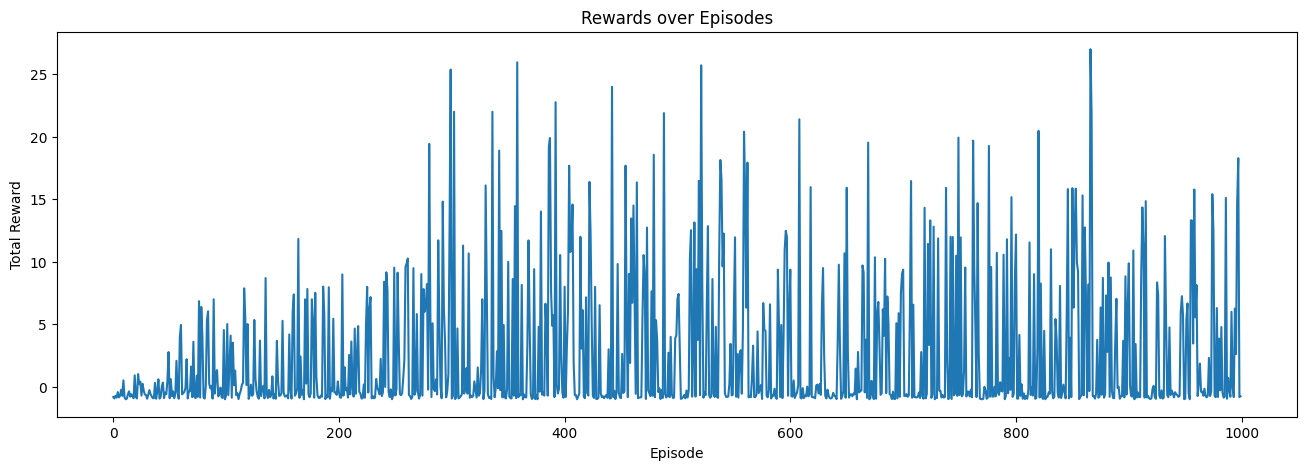

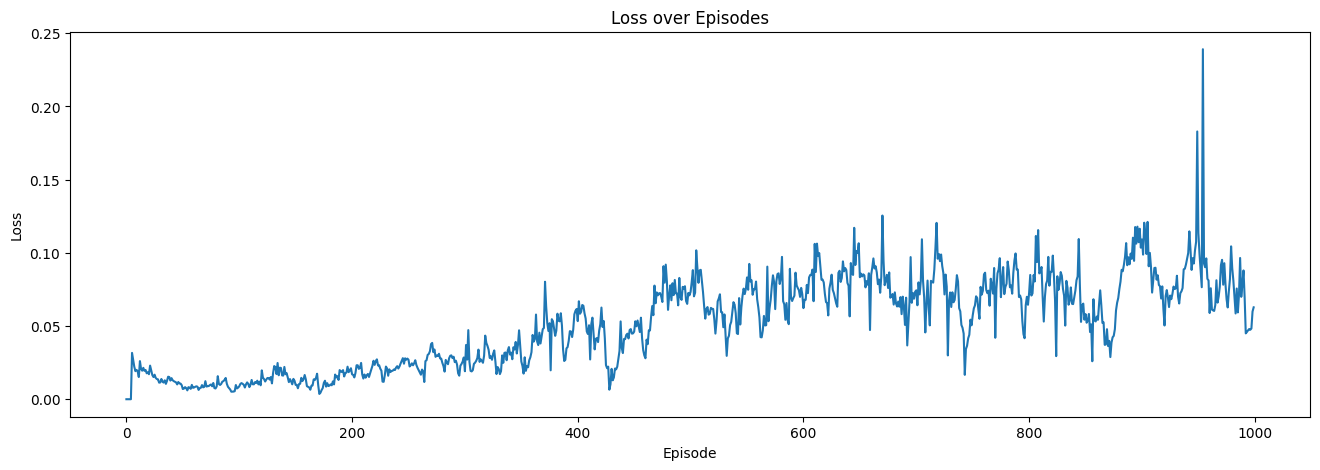

In [14]:

plt.figure(figsize=(16, 5))
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Rewards over Episodes')
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss over Episodes')
plt.show()


Inference

In [16]:
env = UnityEnvironment(file_name="unity_builds/snake", seed=1, side_channels=[], no_graphics=False)
env.reset()

behaviour_name = list(env.behavior_specs)[0]
spec = env.behavior_specs[behaviour_name]

n_actions = spec.action_spec.discrete_branches[0]
state, _ = env.get_steps(behaviour_name)
state = state.obs[0]
# n_observations = len(state)
n_observations = spec.observation_specs[0].shape[0]

# policy_net = DQN(n_observations, n_actions).to(device)
# policy_net = DuelingDQN(n_observations, n_actions).to(device)
# policy_net.load_state_dict(torch.load('weights/large_observations/4k/policy_net.pth'))
# policy_net.load_state_dict(torch.load('weights/policy_net.pth'))
for t in range(5):
    env.reset()
    decision_steps, terminal_steps = env.get_steps(behaviour_name)
    state = decision_steps.obs[0]
    state = torch.tensor(state, dtype=torch.float32, device=device)
    for i in range(100):
        with torch.no_grad():
            action = policy_net(state).max(1).indices.view(1, 1)
    
        action_tuple = ActionTuple()
        action_tuple.add_discrete(action.cpu().numpy())
        env.set_actions(behaviour_name, action_tuple)
        env.step()

        decision_steps, terminal_steps = env.get_steps(behaviour_name)
        observation = decision_steps.obs[0]
        done = len(decision_steps) == 0
        terminated = len(terminal_steps) > 0

        if done or terminated:
            break
        state = torch.tensor(observation, dtype=torch.float32, device=device)
env.close()